# **Lab 8b: Zero-shot Object Detection**
Original Notebook is available [here](https://github.com/huggingface/notebooks/blob/main/examples/zeroshot_object_detection_with_owlvit.ipynb). This notebook was adapted by Prof. Nils Murrugarra from Univ of Pittsburgh.

# Getting started with Owl-ViT

In this notebook, we are going to run the [OWL-ViT](https://arxiv.org/abs/2205.06230) model (an open-vocabulary object detection model) by Google Research on scikit-image samples images.

## OWL-ViT: A Quick Intro
OWL-ViT is an open-vocabulary object detector. Given an image and one or multiple free-text queries, it finds objects matching the queries in the image. Unlike traditional object detection models, OWL-ViT is not trained on labeled object datasets and leverages multi-modal representations to perform open-vocabulary detection.

OWL-ViT uses CLIP with a ViT-like Transformer as its backbone to get multi-modal visual and text features. To use CLIP for object detection, OWL-ViT removes the final token pooling layer of the vision model and attaches a lightweight classification and box head to each transformer output token. Open-vocabulary classification is enabled by replacing the fixed classification layer weights with the class-name embeddings obtained from the text model. The authors first train CLIP from scratch and fine-tune it end-to-end with the classification and box heads on standard detection datasets using a bipartite matching loss. One or multiple text queries per image can be used to perform zero-shot text-conditioned object detection.

![owlvit architecture](https://raw.githubusercontent.com/google-research/scenic/a41d24676f64a2158bfcd7cb79b0a87673aa875b/scenic/projects/owl_vit/data/owl_vit_schematic.png)

## Set-up environment

First, we install the HuggingFace Transformers library (from source for now, as the model was recently added to the library and is under active development). This might take a few minutes.

In [1]:
!pip install transformers==4.55.0 # for compatibility issues

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1


**Optional:** Install Pillow, matplotlib and OpenCV if you are running this notebook locally.

In [2]:
!pip install Pillow
!pip install matplotlib
!pip install opencv-python

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [3]:
from transformers.utils import send_example_telemetry

send_example_telemetry("zeroshot_object_detection_with_owlvit_notebook", framework="pytorch")

## Load pre-trained model and processor

Let's first apply the image preprocessing and tokenize the text queries using `OwlViTProcessor`. The processor will resize the image(s), scale it between [0-1] range and normalize it across the channels using the mean and standard deviation specified in the original codebase.


Text queries are tokenized using a CLIP tokenizer and stacked to output tensors of shape [batch_size * num_max_text_queries, sequence_length]. If you are inputting more than one set of (image, text prompt/s), num_max_text_queries is the maximum number of text queries per image across the batch. Input samples with fewer text queries are padded.

In [4]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

## Preprocess input image and text queries

Let's use the image of astronaut Eileen Collins to test OWL-ViT. It's part of the [NASA](https://www.nasa.gov/multimedia/imagegallery/index.html) Great Images dataset.

You can use one or multiple text prompts per image to search for the target object(s). Let's start with a simple example where we search for multiple objects in a single image.

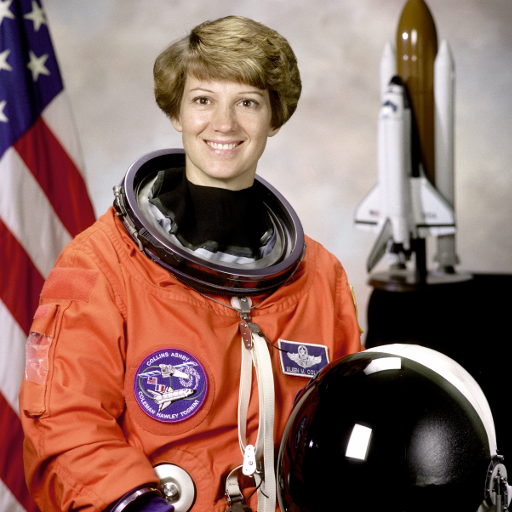

In [11]:
import cv2
import skimage
import numpy as np
from PIL import Image

# Download sample image
image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

# Text queries to search the image for
text_queries = ["human face", "rocket", "nasa badge", "star-splanged banner"] # 1st query
# text_queries = ["rocket", "...", "..."] # 2nd query
# text_queries = ["face", "rocket", "nasa badge", "star-splanged banner", "flag", "helmet", "hair"] # 3rd query
# text_queries = ["human face", "rocket", "nasa badge", "star-splanged banner", "flag", "helmet", "human hair", "human eye", "plane", "smile", "circle"] # 4th query

image

In [12]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [13]:
# Process image and text inputs
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

input_ids: torch.Size([4, 16])
attention_mask: torch.Size([4, 16])
pixel_values: torch.Size([1, 3, 768, 768])


## Forward pass

Now we can pass the inputs to our OWL-ViT model to get object detection predictions.

`OwlViTForObjectDetection` model outputs the prediction logits, boundary boxes and class embeddings, along with the image and text embeddings outputted by the `OwlViTModel`, which is the CLIP backbone.

In [14]:
# Set model in evaluation mode
model = model.to(device)
model.eval()

# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([1, 576, 4])
pred_boxes: shape of torch.Size([1, 576, 4])
text_embeds: shape of torch.Size([1, 4, 512])
image_embeds: shape of torch.Size([1, 24, 24, 768])
class_embeds: shape of torch.Size([1, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([4, 16, 512])
pooler_output: shape of torch.Size([4, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


## Draw predictions on image

Let's draw the predictions / found objects on the input image. Remember the found objects correspond to the input text queries.

In [15]:
import matplotlib.pyplot as plt

from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()

# Load example image
image_size = model.config.vision_config.image_size
image = mixin.resize(image, image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.1

# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

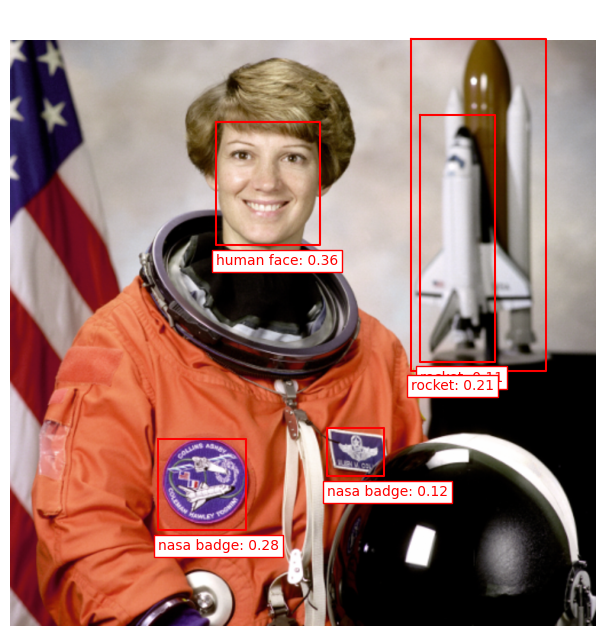

In [16]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue

      cx, cy, w, h = box
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })

plot_predictions(input_image, text_queries, scores, boxes, labels)

# Acknowledgements
Original code is available [here](https://github.com/huggingface/notebooks/blob/main/examples/zeroshot_object_detection_with_owlvit.ipynb). We used a portion of the notebook for teaching purposes.